### Persons in the geographical space

We present various methods of spatialising the birthplaces of our population.

Cf. Sparqlbook [Import birth places](../../sparqlbooks/wdt_import_birth_places.sparqlbook.md)

In [1]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import LineString
from shapely import wkt

import scipy.stats as stats

from geopandas.tools import sjoin
#from geodatasets import get_path

In [2]:
### Librairie à installer dans l'environnement conda (si on exécute en local)
# qui sera choisi pour exécuter le carnet
from SPARQLWrapper import SPARQLWrapper, JSON, TURTLE, XML, RDFXML


import networkx as nx
from networkx.algorithms import bipartite

import matplotlib.pyplot as plt
import matplotlib.patches as patches


import plotly.express as px
import plotly.graph_objects as go

import json

import numpy as np
import seaborn as sns
import math
import os

In [3]:
### Librairies déjà installées avec Python
import pprint
import csv


from shutil import copyfile


In [4]:
### Importer un module de fonctions crées ad hoc
##  ATTENTION : le fichier 'sparql_functions.py' doit se trouver 
#   dans un dossier qui se situe dans le chemin ('path') de recherche
#   vu par le présent carnet Jupyter afin que
#   l'importation fonctionne correctement

import sys
from importlib import reload

# Add parent directory to the path
sys.path.insert(0, '..')

### If you want to add the parent-parent directory,
sys.path.insert(0, '../..')


import sparql_functions as spqf
import network_analysis_functions as naf

In [5]:
print(reload(naf))  

<module 'network_analysis_functions' from '/home/Aplication numerique /network_analysis_functions.py'>


## Geo data

[Word Regions (ESRI)](https://hub.arcgis.com/datasets/a79a3e4dc55343b08543b1b6133bfb90/explore?location=-0.027457%2C0.000000%2C0.88). For personal use only

In [6]:
world_filepath = 'geo_data/esri/World_Regions_6144914380456424035.geojson'
world = gpd.read_file(world_filepath)
world.head()


,FID,REGION,SQMI,SQKM,geometry
0,1,Asiatic Russia,4.987737e+06,1.291823e+07,"MULTIPOLYGON (((-179.99999 68.98009, -179.9580..."
1,2,Australia/New Zealand,3.077219e+06,7.969992e+06,"MULTIPOLYGON (((158.88218 -54.71139, 158.87967..."
2,3,Caribbean,8.919361e+04,2.310113e+05,"MULTIPOLYGON (((-60.92305 10.79722, -60.94445 ..."
3,4,Central America,9.576923e+05,2.480422e+06,"MULTIPOLYGON (((-81.67847 7.38861, -81.64945 7..."
4,5,Central Asia,1.612212e+06,4.175626e+06,"POLYGON ((53.90564 37.35086, 53.67731 37.33536..."


In [7]:
print(world)

    FID                 REGION          SQMI          SQKM  \
0     1         Asiatic Russia  4.987737e+06  1.291823e+07   
1     2  Australia/New Zealand  3.077219e+06  7.969992e+06   
2     3              Caribbean  8.919361e+04  2.310113e+05   
3     4        Central America  9.576923e+05  2.480422e+06   
4     5           Central Asia  1.612212e+06  4.175626e+06   
5     6         Eastern Africa  2.469289e+06  6.395453e+06   
6     7           Eastern Asia  4.460525e+06  1.155275e+07   
7     8         Eastern Europe  7.293090e+05  1.888909e+06   
8     9        European Russia  1.541719e+06  3.993050e+06   
9    10              Melanesia  2.016440e+05  5.222576e+05   
10   11             Micronesia  9.970244e+02  2.582292e+03   
11   12          Middle Africa  2.544044e+06  6.589069e+06   
12   13        Northern Africa  3.191543e+06  8.266092e+06   
13   14              Polynesia  1.586108e+04  4.108018e+04   
14   15          South America  6.856255e+06  1.775769e+07   
15   16 

In [8]:
### Inspect the projection
pprint.pprint(world.crs)

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich



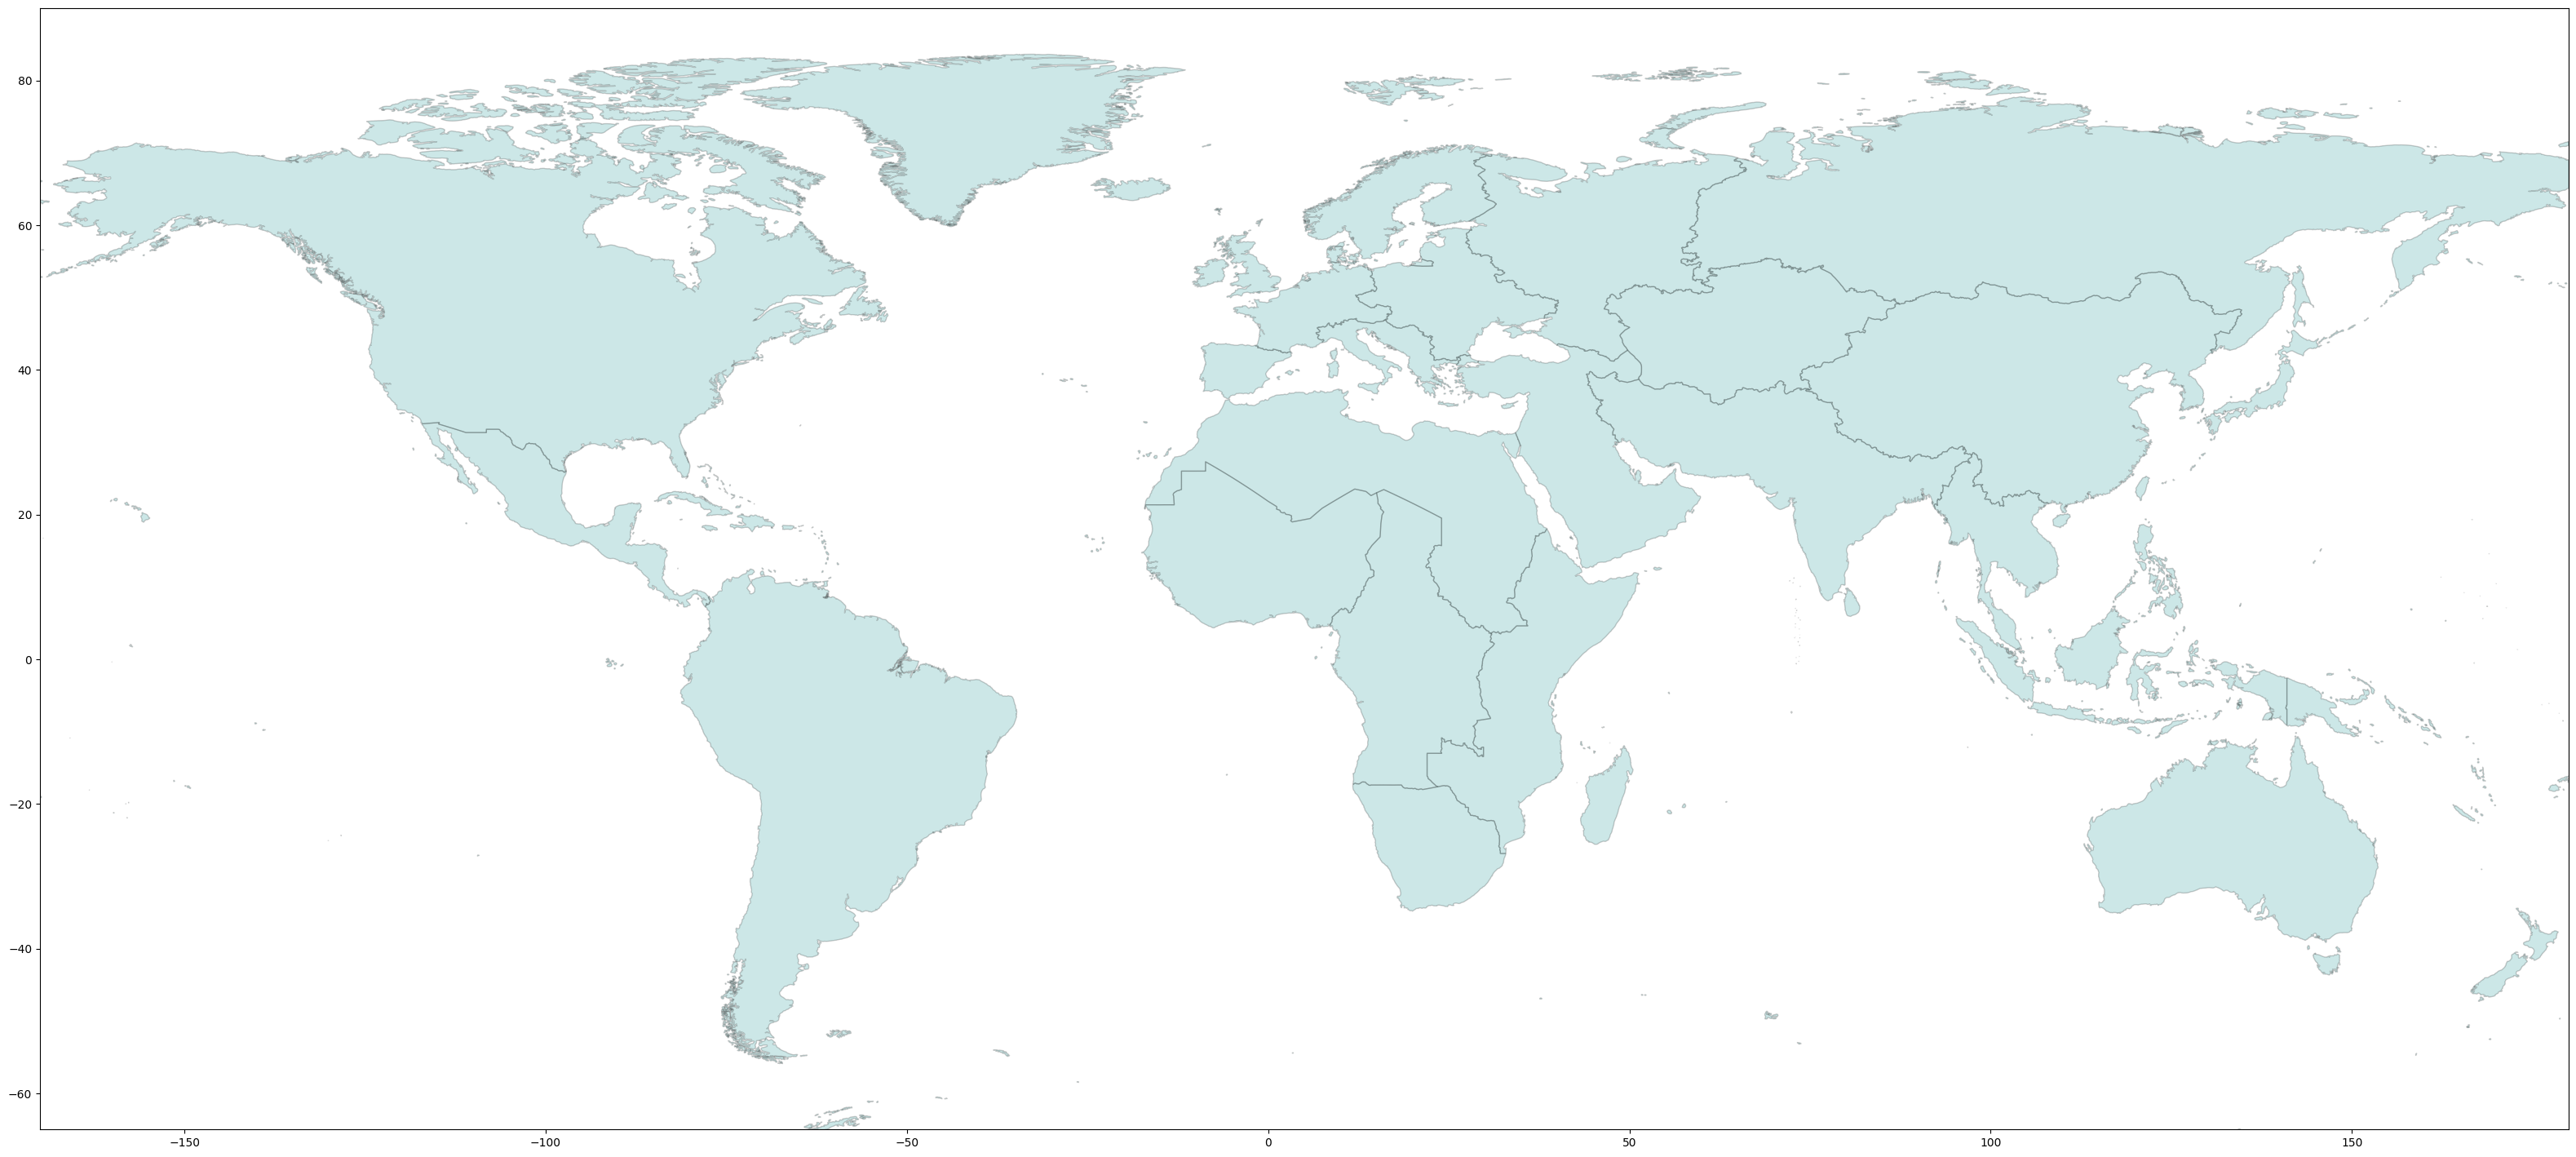

In [9]:
### Draw the world map

## GeoPandas documentation
# https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoDataFrame.plot.html

# If we want to exclude the Antarctic region
world.clip([-180.0, -10.0, 180.0, 90.0])

ax = world.plot(color="DarkCyan", alpha=0.2, edgecolor="black", figsize=(40,30))

# If we want to exclude the Antarctic region
ax.set_xlim(-170,180)
ax.set_ylim(-65, 90)


plt.show()



## Get the data from the triplestore



In [10]:
## define SPARQL enpoint
endpoint = "https://ag16vva57r0v2dln.allegrograph.cloud/repositories/nobel-laureats"

In [11]:
### This query eliminates double names of persons and places,
# and double locations for the same place, and multiple birth dates
query = """
### Nombre de personnes
PREFIX franzOption_defaultDatasetBehavior: <franz:rdf>
PREFIX wd: <http://www.wikidata.org/entity/>
PREFIX wdt: <http://www.wikidata.org/prop/direct/>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>

SELECT ?person 
        (MIN(?personLabel) AS ?persLabel) 
        (MIN(?bDate) AS ?birthDate)
         ?geoPlace 
        (MIN(?placeLabel) AS ?geoPlaceLabel)
        (MIN(?location) AS ?minLocation)
WHERE {
    GRAPH <https://github.com/VericaD/nobel_laureates_pc/blob/main/graph/wikidata-imported-data.md>
        {
            ?person a wd:Q5;
                rdfs:label ?personLabel;
                wdt:P569 ?bDate;
                wdt:P19 ?geoPlace.
            ?geoPlace wdt:P625 ?location;
                rdfs:label ?placeLabel.   
          }
}
GROUP BY ?person ?geoPlace
ORDER BY ?person ?geoPlace
"""

In [12]:
### Excecute the query and transform result to list
try:
    qr = spqf.get_json_sparql_result(endpoint,query)
    out = [l for l in spqf.sparql_result_to_list(qr)]
    print(len(out))
    pprint.pprint(out[101:103])
except Exception as e:
    print(e)    


773
[['http://www.wikidata.org/entity/Q123022',
  'Felix Bloch',
  '1905',
  'http://www.wikidata.org/entity/Q72',
  'Zurich',
  'Point(8.541111111 47.374444444)'],
 ['http://www.wikidata.org/entity/Q123026',
  'Charles Édouard Guillaume',
  '1861',
  'http://www.wikidata.org/entity/Q628354',
  'Fleurier',
  'Point(6.58333 46.9)']]


## Inspect the data


In [13]:
### Create and inspect the dataframe
df_p = pd.DataFrame(out)
df_p.head(1)

,0,1,2,3,4,5
0,http://www.wikidata.org/entity/Q1002250,Duncan Haldane,1951,http://www.wikidata.org/entity/Q84,London,Point(-0.1275 51.507222222)


In [14]:
### Add column names and inspect length of dataframe
df_p.columns = ['uriPer', 'labelPer', 'birthYear', 'uriPlace', 'labelPlace',
                'geometry']
print('Number: ',len(df_p))
df_p.iloc[10:13,:]

Number:  773


,uriPer,labelPer,birthYear,uriPlace,labelPlace,geometry
10,http://www.wikidata.org/entity/Q102483,Jaroslav Seifert,1901,http://www.wikidata.org/entity/Q378120,Žižkov,Point(14.4628 50.0872)
11,http://www.wikidata.org/entity/Q102804,Henri Moissan,1852,http://www.wikidata.org/entity/Q90,Paris,Point(2.352222222 48.856666666)
12,http://www.wikidata.org/entity/Q102822,Jacobus Henricus van 't Hoff,1852,http://www.wikidata.org/entity/Q34370,Rotterdam,Point(4.48 51.92)


#### Save dataframe to CSV

In [15]:
file_add = 'data/geoloc_persons_birth.csv'
df_p.to_csv(file_add, index=False, sep=',', quotechar='"')

#### Reload dataframe from CSV if needed

In [16]:
### Load from CSV if needed
file_add = 'data/geoloc_persons_birth.csv'

df_p=pd.read_csv(file_add)
print(len(df_p))
df_p.head(2)

773


,uriPer,labelPer,birthYear,uriPlace,labelPlace,geometry
0,http://www.wikidata.org/entity/Q1002250,Duncan Haldane,1951,http://www.wikidata.org/entity/Q84,London,Point(-0.1275 51.507222222)
1,http://www.wikidata.org/entity/Q102034,Ronald Ross,1857,http://www.wikidata.org/entity/Q588817,Almora,Point(79.67 29.62)


### Treat multiple birth places

In [17]:
### Prepare a field that concatenates the values
# for places 
df_p['concat_place'] = df_p.apply(lambda x: (x.labelPlace + ';' + x.uriPlace + ';' + x.geometry), axis=1)

In [18]:
### Aggregate the places per person

df_pgr=df_p[['uriPer', 'labelPer', 'birthYear', 'concat_place']].groupby(['uriPer', 'labelPer', 'birthYear'],
               as_index=False)\
.agg({'concat_place': '|'.join})
print('Number of persons in dataframe: ', len(df_pgr), '\n---')
df_pgr.head(3)


Number of persons in dataframe:  766 
---


,uriPer,labelPer,birthYear,concat_place
0,http://www.wikidata.org/entity/Q1002250,Duncan Haldane,1951,London;http://www.wikidata.org/entity/Q84;Poin...
1,http://www.wikidata.org/entity/Q102034,Ronald Ross,1857,Almora;http://www.wikidata.org/entity/Q588817;...
2,http://www.wikidata.org/entity/Q102250,Peter Agre,1949,Northfield;http://www.wikidata.org/entity/Q996...


In [19]:
### Verify that persons are unique
pers_grouped = df_pgr.groupby('uriPer').size().sort_values(ascending=False)
print('Number of unique persons: ', len(pers_grouped), '\n---')
# print(pers_grouped.describe())
pers_grouped.head()

Number of unique persons:  766 
---


uriPer
http://www.wikidata.org/entity/Q983858     1
http://www.wikidata.org/entity/Q1002250    1
http://www.wikidata.org/entity/Q102034     1
http://www.wikidata.org/entity/Q102250     1
http://www.wikidata.org/entity/Q102266     1
dtype: int64

In [20]:
### This persons has three birth dates in the orginal data
# this is now cleaned up in the SPARQL query
df_pgr.loc[df_pgr.uriPer.str.contains('Q1002250')]

,uriPer,labelPer,birthYear,concat_place
0,http://www.wikidata.org/entity/Q1002250,Duncan Haldane,1951,London;http://www.wikidata.org/entity/Q84;Poin...


In [21]:
df_pgr.loc[df_pgr.uriPer.str.contains('Q1002250')].head()

,uriPer,labelPer,birthYear,concat_place
0,http://www.wikidata.org/entity/Q1002250,Duncan Haldane,1951,London;http://www.wikidata.org/entity/Q84;Poin...


In [22]:
### Count the birth places
# The most frequent, first

df_pgr['number'] = df_pgr.concat_place.apply(lambda x : len(x.split('|')))
df_pgr.sort_values("number",ascending=False).head()

,uriPer,labelPer,birthYear,concat_place,number
546,http://www.wikidata.org/entity/Q45970,Czesław Miłosz,1911,Šiauliai;http://www.wikidata.org/entity/Q13471...,2
669,http://www.wikidata.org/entity/Q765,Dario Fo,1926,Sangiano;http://www.wikidata.org/entity/Q39790...,2
626,http://www.wikidata.org/entity/Q6538,Günter Grass,1927,Gdańsk;http://www.wikidata.org/entity/Q1792;Po...,2
661,http://www.wikidata.org/entity/Q75612,Isaac Bashevis Singer,1904,Leoncin;http://www.wikidata.org/entity/Q209341...,2
424,http://www.wikidata.org/entity/Q271532,John Sulston,1942,Fulmer;http://www.wikidata.org/entity/Q2216430...,2


In [23]:
### An example
pprint.pprint(str(df_pgr.loc[df_pgr.uriPer.str.contains('Q1002250')]['concat_place'].to_list()))

"['London;http://www.wikidata.org/entity/Q84;Point(-0.1275 51.507222222)']"


In [24]:
### Number of persons with more then one birth place:
print(len(df_pgr[df_pgr.number > 1]), '\n-----')

### Distribution of multiple places
print(df_pgr.number.describe())



7 
-----
count    766.000000
mean       1.009138
std        0.095219
min        1.000000
25%        1.000000
50%        1.000000
75%        1.000000
max        2.000000
Name: number, dtype: float64


#### Cleaning up and result

In [25]:
### Take the first of the birth places
df_pgr["first_place"] = df_pgr.concat_place.apply(lambda x: x.split('|')[0])
df_pgr[['labelPlace', 'uriPlace', 'geometry']]=df_pgr.first_place.str.split(';', expand=True)
df_pgr.sort_values("number",ascending=False).head(3)

,uriPer,labelPer,birthYear,concat_place,number,first_place,labelPlace,uriPlace,geometry
546,http://www.wikidata.org/entity/Q45970,Czesław Miłosz,1911,Šiauliai;http://www.wikidata.org/entity/Q13471...,2,Šiauliai;http://www.wikidata.org/entity/Q13471...,Šiauliai,http://www.wikidata.org/entity/Q134712,Point(23.316666666 55.928055555)
669,http://www.wikidata.org/entity/Q765,Dario Fo,1926,Sangiano;http://www.wikidata.org/entity/Q39790...,2,Sangiano;http://www.wikidata.org/entity/Q39790...,Sangiano,http://www.wikidata.org/entity/Q39790,Point(8.6334 45.8748)
626,http://www.wikidata.org/entity/Q6538,Günter Grass,1927,Gdańsk;http://www.wikidata.org/entity/Q1792;Po...,2,Gdańsk;http://www.wikidata.org/entity/Q1792;Po...,Gdańsk,http://www.wikidata.org/entity/Q1792,Point(18.6540233 54.3482907)


## Group and map birth places

In [26]:
### Group and count the number of persons per birth place
p_gr = df_pgr.groupby(by=['uriPlace', 'labelPlace', 'geometry'], as_index=False).size()
p_gr.columns=['uriPlace', 'labelPlace', 'geometry', 'size']
p_gr.sort_values('size', ascending=False).head(10)


,uriPlace,labelPlace,geometry,size
437,http://www.wikidata.org/entity/Q60,New York City,Point(-74.006111111 40.712777777),30
535,http://www.wikidata.org/entity/Q90,Paris,Point(2.352222222 48.856666666),14
525,http://www.wikidata.org/entity/Q84,London,Point(-0.1275 51.507222222),13
152,http://www.wikidata.org/entity/Q18419,Brooklyn,Point(-73.949722222 40.650833333),12
125,http://www.wikidata.org/entity/Q1741,Vienna,Point(16.3725 48.208333333),11
60,http://www.wikidata.org/entity/Q1297,Chicago,Point(-87.627777777 41.881944444),11
451,http://www.wikidata.org/entity/Q64,Berlin,Point(13.383333333 52.516666666),9
137,http://www.wikidata.org/entity/Q1781,Budapest,Point(19.040833333 47.498333333),7
18,http://www.wikidata.org/entity/Q1055,Hamburg,Point(10.0 53.55),6
122,http://www.wikidata.org/entity/Q1726,Munich,Point(11.575 48.1375),6


In [27]:
### Try first to convert WKT into Point Geometry
# using a geopandas feature
try:
    p_gr['geometry'] = p_gr['geometry'].apply(wkt.loads)
except Exception as e:
    print(e)

In [28]:
### there's a wrong value in the data: find it
try:
    df_pgr['len_coord'] = df_pgr.geometry.apply(lambda x: len(x))
except Exception as e:
    print(e)


In [29]:
df_pgr.sort_values(by='len_coord', ascending=False).head()


,uriPer,labelPer,birthYear,concat_place,number,first_place,labelPlace,uriPlace,geometry,len_coord
459,http://www.wikidata.org/entity/Q309814,Peter C. Doherty,1940,Brisbane;http://www.wikidata.org/entity/Q34932...,1,Brisbane;http://www.wikidata.org/entity/Q34932...,Brisbane,http://www.wikidata.org/entity/Q34932,Point(153.027777777 -27.467777777),34
403,http://www.wikidata.org/entity/Q237499,Edward Tatum,1909,Boulder;http://www.wikidata.org/entity/Q192517...,1,Boulder;http://www.wikidata.org/entity/Q192517...,Boulder,http://www.wikidata.org/entity/Q192517,Point(-105.292777777 40.019444444),34
275,http://www.wikidata.org/entity/Q19009,Edwin McMillan,1907,Redondo Beach;http://www.wikidata.org/entity/Q...,1,Redondo Beach;http://www.wikidata.org/entity/Q...,Redondo Beach,http://www.wikidata.org/entity/Q840678,Point(-118.376944444 33.856388888),34
411,http://www.wikidata.org/entity/Q243196,Dudley R. Herschbach,1932,San Jose;http://www.wikidata.org/entity/Q16553...,1,San Jose;http://www.wikidata.org/entity/Q16553...,San Jose,http://www.wikidata.org/entity/Q16553,Point(-121.872777777 37.304166666),34
334,http://www.wikidata.org/entity/Q206390,John L. Hall,1934,Denver;http://www.wikidata.org/entity/Q16554;P...,1,Denver;http://www.wikidata.org/entity/Q16554;P...,Denver,http://www.wikidata.org/entity/Q16554,Point(-104.984722222 39.739166666),34


In [30]:
df_pgr.loc[df_pgr.labelPlace=='Brisbane']

,uriPer,labelPer,birthYear,concat_place,number,first_place,labelPlace,uriPlace,geometry,len_coord
459,http://www.wikidata.org/entity/Q309814,Peter C. Doherty,1940,Brisbane;http://www.wikidata.org/entity/Q34932...,1,Brisbane;http://www.wikidata.org/entity/Q34932...,Brisbane,http://www.wikidata.org/entity/Q34932,Point(153.027777777 -27.467777777),34


In [31]:
### Drop the row with the wrong value
# or correct it in the original data
try:
    df_pgr=df_pgr.drop(459)
except Exception as e:
    print(e)    

In [32]:
### Re-do grouping after cleaning up
p_gr = df_pgr.groupby(by=['uriPlace', 'labelPlace', 'geometry'], as_index=False).size()
p_gr.columns=['uriPlace', 'labelPlace', 'geometry', 'number']
p_gr.sort_values('number', ascending=False).head(10)


,uriPlace,labelPlace,geometry,number
436,http://www.wikidata.org/entity/Q60,New York City,Point(-74.006111111 40.712777777),30
534,http://www.wikidata.org/entity/Q90,Paris,Point(2.352222222 48.856666666),14
524,http://www.wikidata.org/entity/Q84,London,Point(-0.1275 51.507222222),13
152,http://www.wikidata.org/entity/Q18419,Brooklyn,Point(-73.949722222 40.650833333),12
60,http://www.wikidata.org/entity/Q1297,Chicago,Point(-87.627777777 41.881944444),11
125,http://www.wikidata.org/entity/Q1741,Vienna,Point(16.3725 48.208333333),11
450,http://www.wikidata.org/entity/Q64,Berlin,Point(13.383333333 52.516666666),9
137,http://www.wikidata.org/entity/Q1781,Budapest,Point(19.040833333 47.498333333),7
18,http://www.wikidata.org/entity/Q1055,Hamburg,Point(10.0 53.55),6
122,http://www.wikidata.org/entity/Q1726,Munich,Point(11.575 48.1375),6


In [33]:

### Create a dataframe with the POINT geometry
# https://geopandas.org/en/stable/gallery/create_geopandas_from_pandas.html
birth_gdf = gpd.GeoDataFrame(
    p_gr, 
    ### Use this if no conversion before to geometry
    ## Cf. above:  p_gr['geometry'].apply(wkt.loads)
    geometry=gpd.GeoSeries.from_wkt(p_gr.geometry), 
    crs=4326
)

birth_gdf.head(3)



,uriPlace,labelPlace,geometry,number
0,http://www.wikidata.org/entity/Q100,Boston,POINT (-71.05778 42.36028),5
1,http://www.wikidata.org/entity/Q1001231,Szczawno-Zdrój,POINT (16.25655 50.80352),1
2,http://www.wikidata.org/entity/Q1004614,Savur,POINT (40.88917 37.5375),1


In [34]:
### Inspect the projection
pprint.pprint(birth_gdf.crs)

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich



In [140]:
### Draw the world map

birth_gdf.plot(ax=ax, color="red", markersize=50, alpha=0.5)

ax = world.plot(color="DarkCyan", alpha=0.3, 
                edgecolor="black", linewidth=2, figsize=(80,60))

# If we want to exclude the Antarctic region
ax.set_xlim(-170,180)
ax.set_ylim(-60, 80)

# We can now plot our ``GeoDataFrame``.
birth_gdf.plot(ax=ax, color="red", markersize=birth_gdf["number"] * 10, alpha=0.5)
#birth_gdf.plot(ax=ax, color="red", markersize='number', alpha=0.5)

f_address = "images/birth_places_geopandas.png"
plt.savefig(f_address)
plt.close()

## Use a different projection (Plotly)

In [36]:
birth_gdf.head(1)

,uriPlace,labelPlace,geometry,number
0,http://www.wikidata.org/entity/Q100,Boston,POINT (-71.05778 42.36028),5


In [37]:
### Create columns for long / lat
birth_gdf['long'] = birth_gdf['geometry'].x
birth_gdf['lat'] = birth_gdf['geometry'].y
birth_gdf.head(1)

,uriPlace,labelPlace,geometry,number,long,lat
0,http://www.wikidata.org/entity/Q100,Boston,POINT (-71.05778 42.36028),5,-71.057778,42.360278


In [38]:
birth_gdf_plus1 = birth_gdf.loc[birth_gdf.number>1]

In [145]:
### requires plotly v.5.24 or higher
import plotly
p_size = [int(s/10+2) for s in birth_gdf_plus1['number']]

fig = px.scatter_map(birth_gdf_plus1, lat="lat", lon="long", size=p_size, 
                     hover_name="labelPlace", hover_data=["number"],
                        color_discrete_sequence=["PowderBlue"],  
                        opacity=0.8, zoom=3.5,
                        center=dict(lon=8.5, lat=47),
                        height=500)
fig.update_layout(
    map_style="white-bg",
    map_layers=[
        {
            "below": 'traces',
            "sourcetype": "raster",
            "sourceattribution": "United States Geological Survey",
            "source": [
                "https://basemap.nationalmap.gov/arcgis/rest/services/USGSImageryOnly/MapServer/tile/{z}/{y}/{x}"
            ]
        }
      ])
#fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})

f_address = "interactive_images/birth_places_geological_survey.html"
fig.write_html(f_address)
#fig.show()

In [ ]:
pip install plotly==5.24.0


In [42]:
### Open the world regions ESRI file in geojson format (and not dataframe)
with open('geo_data/esri/World_Regions_6144914380456424035.geojson') as f:
    geojson = json.load(f)

geojson['features'][3]['properties']


{'FID': 4,
 'REGION': 'Central America',
 'SQMI': 957692.30734,
 'SQKM': 2480421.615}

In [43]:
### 

p_size = [int(s/10+2) for s in birth_gdf_plus1['number']]

fig = px.scatter_map(birth_gdf_plus1, lat="lat", lon="long", size=p_size, 
                     hover_name="labelPlace", 
                        color_discrete_sequence=["DodgerBlue"],  zoom=3.5,
                        center=dict(lon=8.5, lat=47),height=600,
                        opacity=0.9)
fig.update_layout(
    map_style="white-bg",
    map_layers=[
        {
            "below": 'traces',
            "sourcetype": "geojson",
            "type":"line",
            "sourceattribution": "ESRI",
            "source": geojson,
            "line": {"width": 0.5},
        }
      ])
f_address = "interactive_images/birth_places_regions.html"
fig.write_html(f_address)
#fig.show()

### Plot the world as a sphere

In [44]:
### Plot on world as a sphere

lon = birth_gdf["long"]
lat= birth_gdf["lat"]
label= birth_gdf["labelPlace"]
size=[s/10 + 3 for s in birth_gdf["number"]]


# Create the figure
fig = go.Figure(data=go.Scattergeo(
    lon=lon,
    lat=lat,
    mode='markers+text',
    marker=dict(size=size,
                color='red'),
    hovertext=label,
    textposition='top center',
    hoverinfo='text',
    hoverlabel=dict(
        bgcolor='white',
        font_size=12,
        font_family='Arial'
    )
))

# Set the projection to orthogonal
fig.update_layout(
    width=800, 
    height=800,
    geo=dict(
        projection=dict(
            type='orthographic'
        )
    )
)

f_address = "interactive_images/birth_places_globus.html"
fig.write_html(f_address)
# Show the plot
#fig.show()

### Join regions and inspect

We use here spatial joins and associate a region to each place

In [45]:
birth_gdf.loc[birth_gdf.labelPlace.str.contains('Petersburg') |
              birth_gdf.labelPlace.str.contains('Moscow')
              ].sort_values('number', ascending=False).head(10)

,uriPlace,labelPlace,geometry,number,long,lat
454,http://www.wikidata.org/entity/Q649,Moscow,POINT (37.6175 55.75056),5,37.617500,55.750556
460,http://www.wikidata.org/entity/Q656,Saint Petersburg,POINT (30.31667 59.95),3,30.316667,59.950000


In [46]:
### GeoPandas spatial join

w_birth_gdf= birth_gdf.sjoin(world)
w_birth_gdf.iloc[[1,5,10]]

,uriPlace,labelPlace,geometry,number,long,lat,index_right,FID,REGION,SQMI,SQKM
1,http://www.wikidata.org/entity/Q1001231,Szczawno-Zdrój,POINT (16.25655 50.80352),1,16.256550,50.803520,7,8,Eastern Europe,7.293090e+05,1.888909e+06
5,http://www.wikidata.org/entity/Q1012031,Wisbech,POINT (0.16031 52.66416),1,0.160311,52.664161,23,24,Northern Europe,6.245039e+05,1.617464e+06
10,http://www.wikidata.org/entity/Q1023529,Platteville,POINT (-90.4775 42.73707),1,-90.477503,42.737069,22,23,Northern America,8.292643e+06,2.147793e+07


In [47]:
### Number of regions
print(len(world))
world.head(1)

25


,FID,REGION,SQMI,SQKM,geometry
0,1,Asiatic Russia,4.987737e+06,12918232.32,"MULTIPOLYGON (((-179.99999 68.98009, -179.9580..."


In [48]:
### Count by region (sum number of each place in the region)
swb = w_birth_gdf.groupby(['FID','REGION'], as_index=False)['number'].sum()
#swb = swb.set_index('FID', drop=False)
print(len(swb))
swb.sort_values('number', ascending=False).head(24)


19


,FID,REGION,number
17,23,Northern America,201
16,22,Western Europe,180
18,24,Northern Europe,125
6,8,Eastern Europe,55
5,7,Eastern Asia,38
13,19,Southern Europe,32
7,9,European Russia,18
1,2,Australia/New Zealand,12
12,18,Southern Asia,9
9,15,South America,8


In [49]:
### Find places in European Russia with most births 
w_birth_gdf.loc[w_birth_gdf.FID==9].sort_values('number',ascending=False).head(2)

,uriPlace,labelPlace,geometry,number,long,lat,index_right,FID,REGION,SQMI,SQKM
454,http://www.wikidata.org/entity/Q649,Moscow,POINT (37.6175 55.75056),5,37.617500,55.750556,8,9,European Russia,1.541719e+06,3993050.089
460,http://www.wikidata.org/entity/Q656,Saint Petersburg,POINT (30.31667 59.95),3,30.316667,59.950000,8,9,European Russia,1.541719e+06,3993050.089


In [50]:
### Normal Pandas join: add polygons to aggregated regions 
geom_swb=pd.merge(world, swb, left_on='FID', right_on='FID', 
                  how='left')

geom_swb.head(3)

,FID,REGION_x,SQMI,SQKM,geometry,REGION_y,number
0,1,Asiatic Russia,4.987737e+06,1.291823e+07,"MULTIPOLYGON (((-179.99999 68.98009, -179.9580...",Asiatic Russia,2.0
1,2,Australia/New Zealand,3.077219e+06,7.969992e+06,"MULTIPOLYGON (((158.88218 -54.71139, 158.87967...",Australia/New Zealand,12.0
2,3,Caribbean,8.919361e+04,2.310113e+05,"MULTIPOLYGON (((-60.92305 10.79722, -60.94445 ...",Caribbean,3.0


In [51]:
"""grp_geo = gpd.GeoDataFrame(
    geom_reg_per, 
    crs=4326
)
"""
### simplify geometry 
## https://www.statology.org/how-to-simplify-geographic-data-using-geopandas/
geom_swb["geometry"] = (
    geom_swb.simplify(tolerance=0.5)
)

In [52]:
max = geom_swb.number.max()

# Create the choropleth map
fig = px.choropleth_map(
    geom_swb,
    geojson=geom_swb.__geo_interface__,
    map_style='white-bg',
    locations=geom_swb.index,
    color='number',  # Replace with your actual column name
    color_continuous_scale='Blues',
    range_color=(0, max),  # Replace with your actual range
    zoom=1,
    hover_name='REGION_x',
    center={'lat': 47, 'lon': 8.5},
    height=600,
    width=800

)

f_address = "interactive_images/birth_places_regions_choropleth.html"
fig.write_html(f_address)
# Show the plot
#fig.show()

## Analyse using periods

In [53]:
### 30 years periods, but some customisations
lc = [1751, 1811, 1851, 1881, 1911, 1941, 1971, 2001]

In [54]:
### convert birthYear to integer
df_pgr.birthYear = df_pgr.birthYear.apply(lambda x : int(x))

In [55]:
try:
    df_pgr = df_pgr.drop('len_coord', axis=1)
except Exception as e:
    print(e)
df_pgr.head(2)

,uriPer,labelPer,birthYear,concat_place,number,first_place,labelPlace,uriPlace,geometry
0,http://www.wikidata.org/entity/Q1002250,Duncan Haldane,1951,London;http://www.wikidata.org/entity/Q84;Poin...,1,London;http://www.wikidata.org/entity/Q84;Poin...,London,http://www.wikidata.org/entity/Q84,Point(-0.1275 51.507222222)
1,http://www.wikidata.org/entity/Q102034,Ronald Ross,1857,Almora;http://www.wikidata.org/entity/Q588817;...,1,Almora;http://www.wikidata.org/entity/Q588817;...,Almora,http://www.wikidata.org/entity/Q588817,Point(79.67 29.62)


In [56]:
### fonction pd.cut : https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.cut.html
# On ajoute une nouvelle colonne qui contient la période sur la base de la liste précédente
# et de la valeur de l'année
df_pgr['periods'] = pd.cut(df_pgr['birthYear'], lc, right=False)

### Transformer le code ajouté pour qu'il soit plus lisible
# noter qu'on a arrondi les valeurs
df_pgr['periods'] = df_pgr['periods'].apply(lambda x : str(int(x.left))+'-'+ str(int(x.right)-1))

# Inspection
df_pgr.iloc[[1,5,10]]

,uriPer,labelPer,birthYear,concat_place,number,first_place,labelPlace,uriPlace,geometry,periods
1,http://www.wikidata.org/entity/Q102034,Ronald Ross,1857,Almora;http://www.wikidata.org/entity/Q588817;...,1,Almora;http://www.wikidata.org/entity/Q588817;...,Almora,http://www.wikidata.org/entity/Q588817,Point(79.67 29.62),1851-1880
5,http://www.wikidata.org/entity/Q102291,Francis William Aston,1877,Harborne;http://www.wikidata.org/entity/Q36992...,1,Harborne;http://www.wikidata.org/entity/Q36992...,Harborne,http://www.wikidata.org/entity/Q3699290,Point(-1.97 52.45),1851-1880
10,http://www.wikidata.org/entity/Q102483,Jaroslav Seifert,1901,Žižkov;http://www.wikidata.org/entity/Q378120;...,1,Žižkov;http://www.wikidata.org/entity/Q378120;...,Žižkov,http://www.wikidata.org/entity/Q378120,Point(14.4628 50.0872),1881-1910


In [57]:
p_gr_per = df_pgr.groupby(by=['uriPlace', 'labelPlace', 'periods', 'geometry'], observed=True, as_index=False).size()
p_gr_per.columns=['uriPlace', 'labelPlace', 'period', 'coordinates', 'size']
#p_grp.geometry = gpd.GeoSeries.from_wkt(p_gr["coordinates"])
p_gr_per.head()


,uriPlace,labelPlace,period,coordinates,size
0,http://www.wikidata.org/entity/Q100,Boston,1881-1910,Point(-71.057777777 42.360277777),1
1,http://www.wikidata.org/entity/Q100,Boston,1911-1940,Point(-71.057777777 42.360277777),3
2,http://www.wikidata.org/entity/Q100,Boston,1941-1970,Point(-71.057777777 42.360277777),1
3,http://www.wikidata.org/entity/Q1001231,Szczawno-Zdrój,1851-1880,Point(16.25655 50.80352),1
4,http://www.wikidata.org/entity/Q1004614,Savur,1941-1970,Point(40.889166666 37.5375),1


In [58]:

### Créer un dataframe geopandas avec une colonne contenant une géométrie 
# https://geopandas.org/en/stable/gallery/create_geopandas_from_pandas.html
birth_p_grp = gpd.GeoDataFrame(
    p_gr_per, 
    ### Here we use it
    geometry=gpd.GeoSeries.from_wkt(p_gr_per.coordinates), crs=4326
)

birth_p_grp.head(3)



,uriPlace,labelPlace,period,coordinates,size,geometry
0,http://www.wikidata.org/entity/Q100,Boston,1881-1910,Point(-71.057777777 42.360277777),1,POINT (-71.05778 42.36028)
1,http://www.wikidata.org/entity/Q100,Boston,1911-1940,Point(-71.057777777 42.360277777),3,POINT (-71.05778 42.36028)
2,http://www.wikidata.org/entity/Q100,Boston,1941-1970,Point(-71.057777777 42.360277777),1,POINT (-71.05778 42.36028)


In [59]:
### Create columns for long / lat
birth_p_grp['long'] = birth_p_grp['geometry'].x
birth_p_grp['lat'] = birth_p_grp['geometry'].y
birth_p_grp.head()

,uriPlace,labelPlace,period,coordinates,size,geometry,long,lat
0,http://www.wikidata.org/entity/Q100,Boston,1881-1910,Point(-71.057777777 42.360277777),1,POINT (-71.05778 42.36028),-71.057778,42.360278
1,http://www.wikidata.org/entity/Q100,Boston,1911-1940,Point(-71.057777777 42.360277777),3,POINT (-71.05778 42.36028),-71.057778,42.360278
2,http://www.wikidata.org/entity/Q100,Boston,1941-1970,Point(-71.057777777 42.360277777),1,POINT (-71.05778 42.36028),-71.057778,42.360278
3,http://www.wikidata.org/entity/Q1001231,Szczawno-Zdrój,1851-1880,Point(16.25655 50.80352),1,POINT (16.25655 50.80352),16.256550,50.803520
4,http://www.wikidata.org/entity/Q1004614,Savur,1941-1970,Point(40.889166666 37.5375),1,POINT (40.88917 37.5375),40.889167,37.537500


In [60]:
# now just plot it on a map with evolution by time
# https://plotly.com/python/animations/
# https://plotly.com/python/scatter-plots-on-maps/

# np.log(s) * 1000
size = [s*5 if s != 0 else 0 for s in birth_p_grp["size"]]




fig = px.scatter_geo(
    birth_p_grp,
    lon="long",
    lat="lat",
    size=size,
    hover_name = "labelPlace",
    animation_frame= "period",
    width=1400, height=600,
    color_discrete_sequence=['red'],
    title="Evolution of birth places through time"
).update_layout(
    # transition_duration=3000,
    #mapbox_style='stamen-watercolor',
    mapbox={"style": "carto-positron", "zoom":2},
    margin={"l": 0, "r": 20, "t": 30, "b": 200}
)



fig.layout.updatemenus[0].buttons[0].args[1]['frame']['duration'] = 2000
fig.layout.updatemenus[0].buttons[0].args[1]['transition']['duration'] = 20

### Enregistrer l'image, puis l'ouvrir dans un autre onglet du navigateur
f_address = "interactive_images/birth_places_periods.html"
fig.write_html(f_address)
# fig.show()
#plt.close()


### Merge persons and territories

This merge provides regions as additional properties of persons

In [62]:
with open('geo_data/esri/World_Regions_6144914380456424035.geojson') as f:
    geojson = json.load(f)

pprint.pprint(geojson['features'][3]['properties'])


{'FID': 4,
 'REGION': 'Central America',
 'SQKM': 2480421.615,
 'SQMI': 957692.30734}


In [63]:
print([f['properties']['FID'] for f in geojson['features']][:3])

[1, 2, 3]


In [64]:
world.head(2)

,FID,REGION,SQMI,SQKM,geometry
0,1,Asiatic Russia,4.987737e+06,1.291823e+07,"MULTIPOLYGON (((-179.99999 68.98009, -179.9580..."
1,2,Australia/New Zealand,3.077219e+06,7.969992e+06,"MULTIPOLYGON (((158.88218 -54.71139, 158.87967..."


In [65]:
### Cleaned up dataframe
df_pgr.iloc[[1,5,10]]

,uriPer,labelPer,birthYear,concat_place,number,first_place,labelPlace,uriPlace,geometry,periods
1,http://www.wikidata.org/entity/Q102034,Ronald Ross,1857,Almora;http://www.wikidata.org/entity/Q588817;...,1,Almora;http://www.wikidata.org/entity/Q588817;...,Almora,http://www.wikidata.org/entity/Q588817,Point(79.67 29.62),1851-1880
5,http://www.wikidata.org/entity/Q102291,Francis William Aston,1877,Harborne;http://www.wikidata.org/entity/Q36992...,1,Harborne;http://www.wikidata.org/entity/Q36992...,Harborne,http://www.wikidata.org/entity/Q3699290,Point(-1.97 52.45),1851-1880
10,http://www.wikidata.org/entity/Q102483,Jaroslav Seifert,1901,Žižkov;http://www.wikidata.org/entity/Q378120;...,1,Žižkov;http://www.wikidata.org/entity/Q378120;...,Žižkov,http://www.wikidata.org/entity/Q378120,Point(14.4628 50.0872),1881-1910


In [66]:
### create a geo data frame

gdf_pgr = gpd.GeoDataFrame(
    df_pgr, 
    ### Here we use it
    geometry=gpd.GeoSeries.from_wkt(df_pgr.geometry), crs=4326
)

gdf_pgr.head(3)



,uriPer,labelPer,birthYear,concat_place,number,first_place,labelPlace,uriPlace,geometry,periods
0,http://www.wikidata.org/entity/Q1002250,Duncan Haldane,1951,London;http://www.wikidata.org/entity/Q84;Poin...,1,London;http://www.wikidata.org/entity/Q84;Poin...,London,http://www.wikidata.org/entity/Q84,POINT (-0.1275 51.50722),1941-1970
1,http://www.wikidata.org/entity/Q102034,Ronald Ross,1857,Almora;http://www.wikidata.org/entity/Q588817;...,1,Almora;http://www.wikidata.org/entity/Q588817;...,Almora,http://www.wikidata.org/entity/Q588817,POINT (79.67 29.62),1851-1880
2,http://www.wikidata.org/entity/Q102250,Peter Agre,1949,Northfield;http://www.wikidata.org/entity/Q996...,1,Northfield;http://www.wikidata.org/entity/Q996...,Northfield,http://www.wikidata.org/entity/Q996544,POINT (-93.16111 44.45833),1941-1970


In [67]:
### spatial join
pgr_reg = gdf_pgr.sjoin(world)
pgr_reg.iloc[[1,5,10]]

,uriPer,labelPer,birthYear,concat_place,number,first_place,labelPlace,uriPlace,geometry,periods,index_right,FID,REGION,SQMI,SQKM
1,http://www.wikidata.org/entity/Q102034,Ronald Ross,1857,Almora;http://www.wikidata.org/entity/Q588817;...,1,Almora;http://www.wikidata.org/entity/Q588817;...,Almora,http://www.wikidata.org/entity/Q588817,POINT (79.67 29.62),1851-1880,17,18,Southern Asia,2.606398e+06,6.750568e+06
5,http://www.wikidata.org/entity/Q102291,Francis William Aston,1877,Harborne;http://www.wikidata.org/entity/Q36992...,1,Harborne;http://www.wikidata.org/entity/Q36992...,Harborne,http://www.wikidata.org/entity/Q3699290,POINT (-1.97 52.45),1851-1880,23,24,Northern Europe,6.245039e+05,1.617464e+06
10,http://www.wikidata.org/entity/Q102483,Jaroslav Seifert,1901,Žižkov;http://www.wikidata.org/entity/Q378120;...,1,Žižkov;http://www.wikidata.org/entity/Q378120;...,Žižkov,http://www.wikidata.org/entity/Q378120,POINT (14.4628 50.0872),1881-1910,7,8,Eastern Europe,7.293090e+05,1.888909e+06


In [68]:
pgr_reg = pgr_reg.drop(['concat_place', 'number', 'first_place',
                        'index_right', 'SQMI','SQKM'], axis=1)
pgr_reg.head(2)

,uriPer,labelPer,birthYear,labelPlace,uriPlace,geometry,periods,FID,REGION
0,http://www.wikidata.org/entity/Q1002250,Duncan Haldane,1951,London,http://www.wikidata.org/entity/Q84,POINT (-0.1275 51.50722),1941-1970,24,Northern Europe
1,http://www.wikidata.org/entity/Q102034,Ronald Ross,1857,Almora,http://www.wikidata.org/entity/Q588817,POINT (79.67 29.62),1851-1880,18,Southern Asia


### Group by regions and periods

In [69]:
reg_per=pgr_reg.groupby(['FID', 'REGION', 'periods'], observed=True, as_index=False).size()
reg_per.head(3)

,FID,REGION,periods,size
0,1,Asiatic Russia,1881-1910,1
1,1,Asiatic Russia,1971-2000,1
2,2,Australia/New Zealand,1851-1880,1


In [70]:
### Merge with world to get polygons
geom_reg_per=pd.merge(reg_per, world, left_on='FID', right_on='FID')
geom_reg_per=geom_reg_per.drop(['REGION_y','SQMI','SQKM'], axis=1)
geom_reg_per.columns=['FID', 'name','periods','number','geometry']
geom_reg_per.head(2)

,FID,name,periods,number,geometry
0,1,Asiatic Russia,1881-1910,1,"MULTIPOLYGON (((-179.99999 68.98009, -179.9580..."
1,1,Asiatic Russia,1971-2000,1,"MULTIPOLYGON (((-179.99999 68.98009, -179.9580..."


In [71]:
### Transform to geoDataFrame
grp_geo = gpd.GeoDataFrame(
    geom_reg_per, 
    crs=4326
)
grp_geo.head(2)

,FID,name,periods,number,geometry
0,1,Asiatic Russia,1881-1910,1,"MULTIPOLYGON (((-179.99999 68.98009, -179.9580..."
1,1,Asiatic Russia,1971-2000,1,"MULTIPOLYGON (((-179.99999 68.98009, -179.9580..."


In [72]:
print(len(grp_geo))

64


In [73]:
### Tableau de contingence
X = "REGION"
Y = "periods"  # "0"

pv_per_reg = pgr_reg[[X,Y]].pivot_table(index=Y,columns=X,observed=True, aggfunc=len,margins=True,margins_name="Total").fillna(0).astype(int)
pv_per_reg

REGION,Asiatic Russia,Australia/New Zealand,Caribbean,Central America,Eastern Africa,Eastern Asia,Eastern Europe,European Russia,Northern Africa,Northern America,Northern Europe,South America,Southeastern Asia,Southern Africa,Southern Asia,Southern Europe,Western Africa,Western Asia,Western Europe,Total
periods,,,,,,,,,,,,,,,,,,,,
1811-1850,0,0,0,0,0,0,2,2,0,0,2,0,0,0,0,3,0,0,16,25
1851-1880,0,1,0,0,0,0,10,2,0,6,28,0,1,0,3,8,0,0,42,101
1881-1910,1,4,1,1,0,5,21,7,1,39,34,3,0,1,2,11,0,2,47,180
1911-1940,0,5,2,1,1,21,15,6,3,91,42,5,0,4,3,9,1,2,43,254
1941-1970,0,2,0,1,1,12,7,1,3,64,18,0,0,1,1,1,0,4,32,148
1971-2000,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,3
Total,2,12,3,3,2,38,55,18,7,201,125,8,1,6,9,32,1,8,180,711


In [74]:
df_t = pv_per_reg.T
df_t

periods,1811-1850,1851-1880,1881-1910,1911-1940,1941-1970,1971-2000,Total
REGION,,,,,,,
Asiatic Russia,0,0,1,0,0,1,2
Australia/New Zealand,0,1,4,5,2,0,12
Caribbean,0,0,1,2,0,0,3
Central America,0,0,1,1,1,0,3
Eastern Africa,0,0,0,1,1,0,2
Eastern Asia,0,0,5,21,12,0,38
Eastern Europe,2,10,21,15,7,0,55
European Russia,2,2,7,6,1,0,18
Northern Africa,0,0,1,3,3,0,7


In [96]:
df_t[df_t.Total > 50]


periods,1811-1850,1851-1880,1881-1910,1911-1940,1941-1970,1971-2000,Total
REGION,,,,,,,
Eastern Europe,2,10,21,15,7,0,55
Northern America,0,6,39,91,64,1,201
Northern Europe,2,28,34,42,18,1,125
Western Europe,16,42,47,43,32,0,180
Total,25,101,180,254,148,3,711


In [98]:
df_t[df_t.Total > 50].iloc[:-1][["1851-1880", "1881-1910", "1911-1940", "1941-1970"]]


periods,1851-1880,1881-1910,1911-1940,1941-1970
REGION,,,,
Eastern Europe,10,21,15,7
Northern America,6,39,91,64
Northern Europe,28,34,42,18
Western Europe,42,47,43,32


In [99]:
print(list(df_t.index))

['Asiatic Russia', 'Australia/New Zealand', 'Caribbean', 'Central America', 'Eastern Africa', 'Eastern Asia', 'Eastern Europe', 'European Russia', 'Northern Africa', 'Northern America', 'Northern Europe', 'South America', 'Southeastern Asia', 'Southern Africa', 'Southern Asia', 'Southern Europe', 'Western Africa', 'Western Asia', 'Western Europe', 'Total']


In [100]:
grp_geo.head(1)

,FID,name,periods,number,geometry
0,1,Asiatic Russia,1881-1910,1,"MULTIPOLYGON (((-179.99999 68.98009, -175.4636..."


In [101]:
sel_geo = grp_geo[grp_geo.name.isin(list(df_t.index))].copy(deep=True)
sel_geo.head(2)

,FID,name,periods,number,geometry
0,1,Asiatic Russia,1881-1910,1,"MULTIPOLYGON (((-179.99999 68.98009, -175.4636..."
1,1,Asiatic Russia,1971-2000,1,"MULTIPOLYGON (((-179.99999 68.98009, -175.4636..."


In [102]:
print(grp_geo.crs)

EPSG:4326


In [103]:
grp_geo = gpd.GeoDataFrame(
    geom_reg_per, 
    crs=4326
)

### simplify geometry 
## https://www.statology.org/how-to-simplify-geographic-data-using-geopandas/
grp_geo["geometry"] = (
    grp_geo.simplify(tolerance=0.8)
)

In [104]:
max = grp_geo.number.max()

# Create the choropleth map
fig = px.choropleth_map(
    grp_geo,
    geojson=grp_geo.__geo_interface__,
    locations=grp_geo.index,
    color='number',  # Replace with your actual column name
    color_continuous_scale='Blues',
    range_color=(0, max),  # Replace with your actual range
    zoom=1,
    #map_style='white-bg',
    hover_name='name',
    center={'lat': 47, 'lon': 8.5},
    height=600,
    width=1000,
    animation_frame="periods",
    #title="Temporal evolution of birth regions"

).update_layout(
    # transition_duration=3000,
    #mapbox_style='stamen-watercolor',
    #mapbox={"style": "carto-positron", "zoom":2},
    margin={"l": 0, "r": 20, "t": 30, "b": 200}
)

f_address = "interactive_images/birth_periods_regions_choropleth.html"
fig.write_html(f_address)
# Show the plot
#fig.show()

### Bivariate analysis

In [108]:
D = df_t[df_t.Total > 50].iloc[:-1][["1851-1880", "1881-1910", "1911-1940", "1941-1970"]]

In [129]:
def bivariee_stats(D, figsize=(8,8)):
    ### Valeurs produites par la fonction de la librairie 'stats'
    statistic, p, dof, expected = stats.chi2_contingency(D)

    n = D.sum().sum()

    print('Chi2 :', round(statistic, 2), ', dof :', dof)
    #print('Chi2 :', statistic.round(2), ', dof :',dof)
    print('p-value :', p)


    print('phi2 = inertie (variance totale) :', statistic/n)


    ### Tableau à l'indépendance
    dfe = round(pd.DataFrame(expected),4)

    ### Coéfficient de Cramer
    # https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.contingency.association.html

    vc = stats.contingency.association(D, method='cramer')
    print('Cramer: ', vc)

    ### Situation à l'indépendance
    indep = pd.DataFrame(expected)
    indep.columns = D.columns
    indep.index = D.index

    ### Résidus pondérés (avec le signe)
    ### Doc. :
    #   Rakotomalala, p.240
    residus_ponderes = (round((D-indep)/np.sqrt(indep),2))
    ### Résidus pondérés
    tableau = residus_ponderes

    fig, ax = plt.subplots(figsize=figsize)         
    # Sample figsize in inches
    g = sns.heatmap(tableau, annot=tableau, cmap="coolwarm", linewidths=.5, ax=ax)
    xlabels = tableau.columns
    px = g.set_xticklabels(xlabels, rotation=60, size=8, 
                           ha='right', rotation_mode='anchor')
    ylabels = tableau.index
    py = g.set_yticklabels(ylabels, rotation=20, size=8)
    
    plt.savefig("images/bivariate_plot.png", dpi=300, bbox_inches='tight')
    plt.show()
    

Chi2 : 66.67 , dof : 9
p-value : 6.82525679630432e-11
phi2 = inertie (variance totale) : 0.12368979784845917
Cramer:  0.20305155162212637


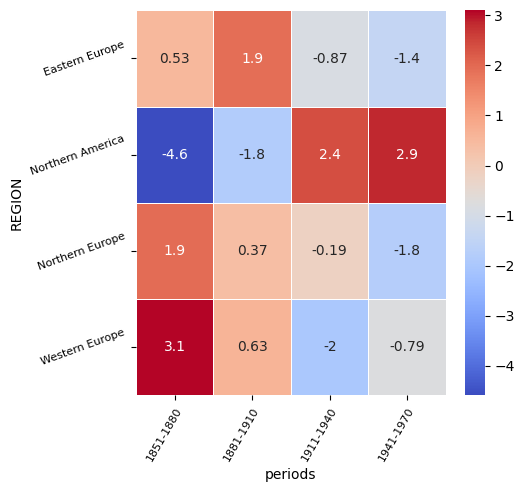

In [130]:
## Appliquer la fonction
bivariee_stats(D, figsize=(5,5))